# Classifying satellite data

* **Products used:** 
[gm_s2_annual](https://explorer.digitalearth.africa/gm_s2_annual)

Source: https://registry.opendata.aws/deafrica-landsat/

Now that the model is ready, we will import the model and get the test data with some query parameters. The test data is selected in such a way that we only select the small regions. Once the model is giving the best results then we predict for the large region by re-entering a new latitude, longitude and larger buffer size.The results are stored in tif files in the disk.


***
## Getting started

To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

### Load Packages

In [2]:
import datacube
import xarray as xr
from joblib import load
import matplotlib.pyplot as plt
from datacube.utils.cog import write_cog

from deafrica_tools.datahandling import load_ard
from deafrica_tools.bandindices import calculate_indices
from deafrica_tools.dask import create_local_dask_cluster
from deafrica_tools.plotting import rgb, display_map
from deafrica_tools.classification import predict_xr

import warnings
warnings.filterwarnings("ignore")


### Set up a dask cluster
This will help keep our memory use down and conduct the analysis in parallel. If you'd like to view the dask dashboard, click on the hyperlink that prints below the cell. You can use the dashboard to monitor the progress of calculations.

In [3]:
create_local_dask_cluster()

<Client: 'tcp://127.0.0.1:38789' processes=1 threads=2, memory=13.11 GB>

In [4]:
model_path = 'results/ml_model.joblib'

testing_locations = {
    '1': (24.4780, 33.0457),
    '2': (22.7712, 28.5223),
    '3': (30.3971, 30.7996),
    '4': (31.1751, 31.2221),
}

buffer = 0.1

dask_chunks = {'x':1000,'y':1000}

results = 'results/'

### Connect to the datacube

In [6]:
dc = datacube.Datacube(app='prediction')

## Import the model

The code below will also re-open the training data we exported from `3_Evaluate_optimize_fit_classifier.ipynb` and grab the column names (features we selected).

In [7]:
model = load(model_path).set_params(n_jobs=1)

## Making a prediction


### Redefining the feature layer function

Because we elected to use all the features extracted in `1_Extract_training_data.ipynb`, we can simply copy-and-paste the `feature_layers` function from the first notebook [Extracting_training_data](1_Extract_training_data.ipynb) into the cell below (this has already been done for you). 

In [8]:
from datacube.testutils.io import rio_slurp_xarray

def feature_layers(query):
    #connect to the datacube
    dc = datacube.Datacube(app='feature_layers')
    
    #load ls8 geomedian
    ds = dc.load(product='gm_s2_annual',
                 **query)
    
    #calculate some band indices
    da = calculate_indices(ds,
                           index=['NDVI','LAI','MNDWI'],
                           drop=False,
                           collection='s2')
    
    #add slope dataset
    url_slope = "https://deafrica-input-datasets.s3.af-south-1.amazonaws.com/srtm_dem/srtm_africa_slope.tif"
    slope = rio_slurp_xarray(url_slope, gbox=ds.geobox)
    slope = slope.to_dataset(name='slope').chunk(dask_chunks)
    
    #merge results into single dataset 
    result = xr.merge([da, slope],compat='override')

    return result.squeeze()

### Set up datacube query

Unless there are measurements that no longer need to be loaded because they were dropped during the feature selection process, these query parameters should match the query params in '1 Extract training data.ipynb'.

In [9]:
# Set up the inputs for the ODC query
time = ('2019')
measurements =  ['blue','green','red','nir','swir_1','swir_2','red_edge_1',
                 'red_edge_2', 'red_edge_3', 'BCMAD', 'EMAD', 'SMAD']
resolution = (-20,20)
output_crs='epsg:6933'

### Loop through test locations and predict

We compute the feature layers for each place mentioned in the 'test locations' dictionary, and then classify the data using the DE Africa function [predict xr](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks/blob/83116e80ebb4f8744e3de74e7a713aadd0a7577a/Tools/deafrica_tools/classification.py#L237)

The 'predict xr' function is a xarray wrapper over the sklearn estimator methods '.predict()' and '.predict proba()', and it uses [dask-ml](https://ml.dask.org/) [ParallelPostFit](https://ml.dask.org/modules/generated/dask_ml.wrappers.ParallelPostFit.html) 'Predict xr' can compute predictions and probability estimates, as well as return the input feature layers. For additional information on this function's capabilities, see the [documentation](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks/blob/83116e80ebb4f8744e3de74e7a713aadd0a7577a/Tools/deafrica_tools/classification.py#L247).

In [10]:
predictions = []

for key, value in testing_locations.items():
    
    print('working on: ' + key)

     # generate a datacube query object
    query = {
        'x': (value[1]-buffer, value[1]+buffer),
        'y': (value[0]+buffer, value[0]-buffer),
        'time': time,
        'measurements': measurements,
        'resolution': resolution,
        'output_crs': output_crs,
        'dask_chunks' : dask_chunks,
    }

    #calculate features
    data = feature_layers(query)

    #predict using the imported model
    predicted = predict_xr(model,
                           data,
                           proba=True,
                           persist=True,
                           clean=True,
                           return_input=True
                          ).compute()
        
    predictions.append(predicted)
    

working on: 1
predicting...
   probabilities...
   input features...
working on: 2
predicting...
   probabilities...
   input features...
working on: 3
predicting...
   probabilities...
   input features...
working on: 4
predicting...
   probabilities...
   input features...


### Plotting results

In the plots below you'll see on the left the classified image (green = crop, white = non-crop), in the centre a true-colour image of the region, and on the right an image of the prediction probabilities.

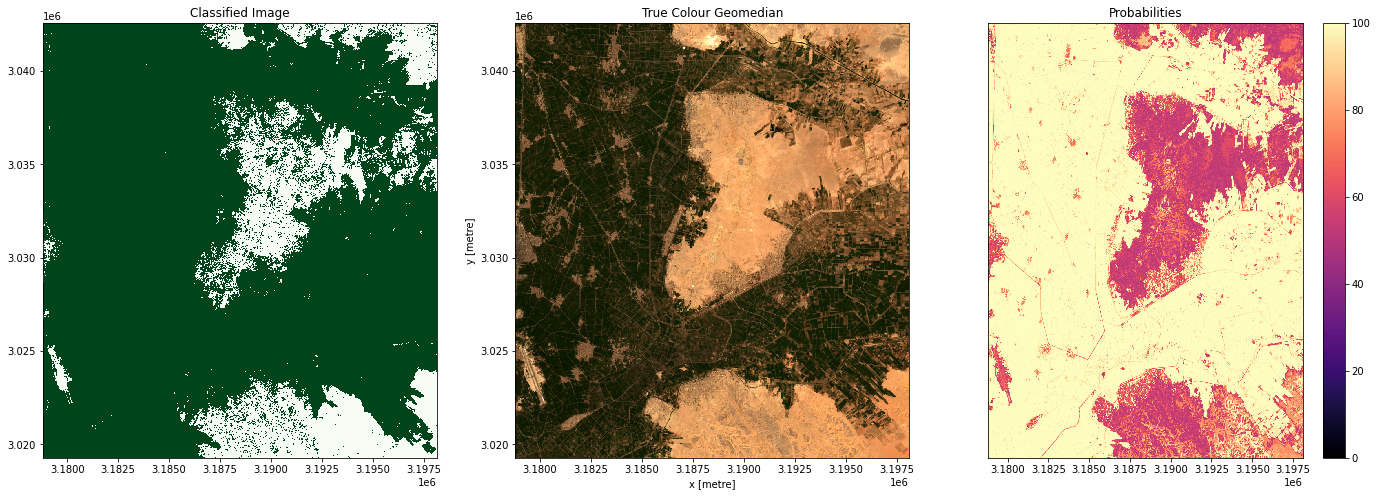

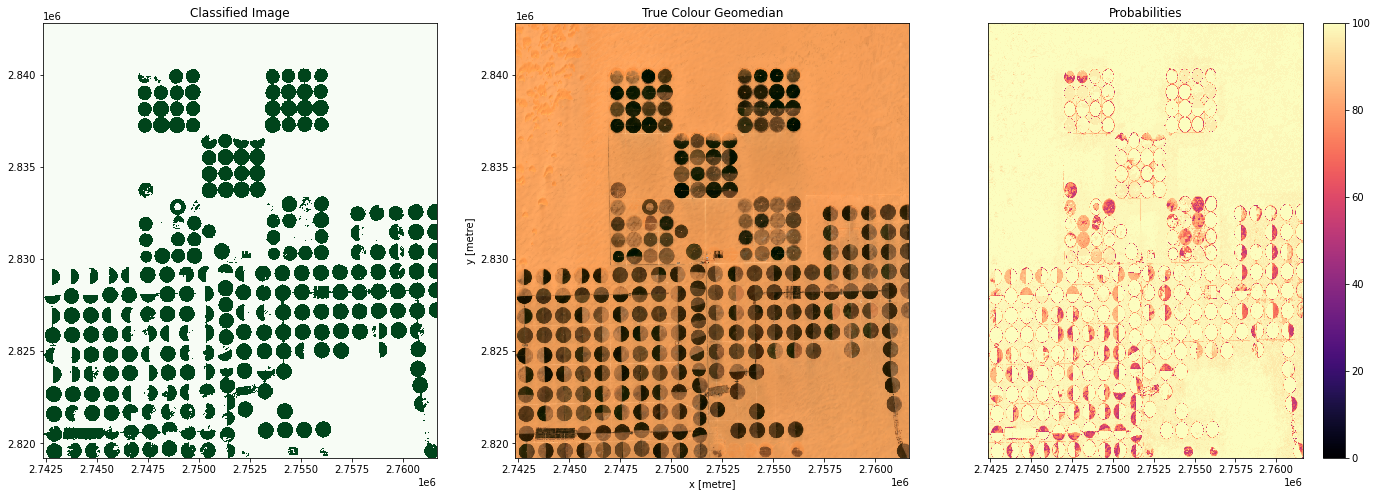

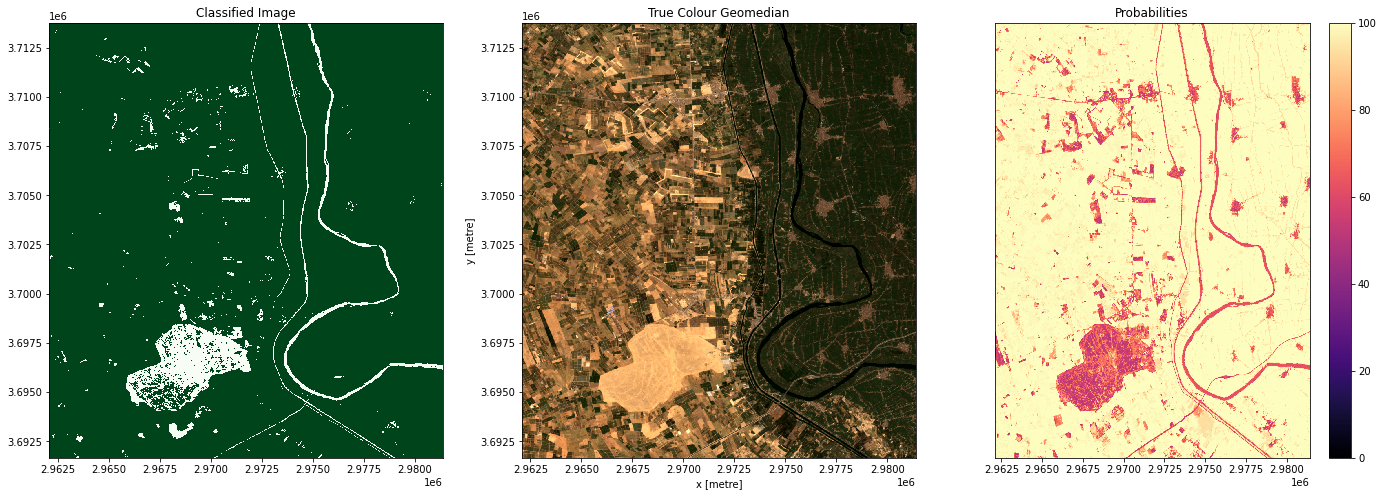

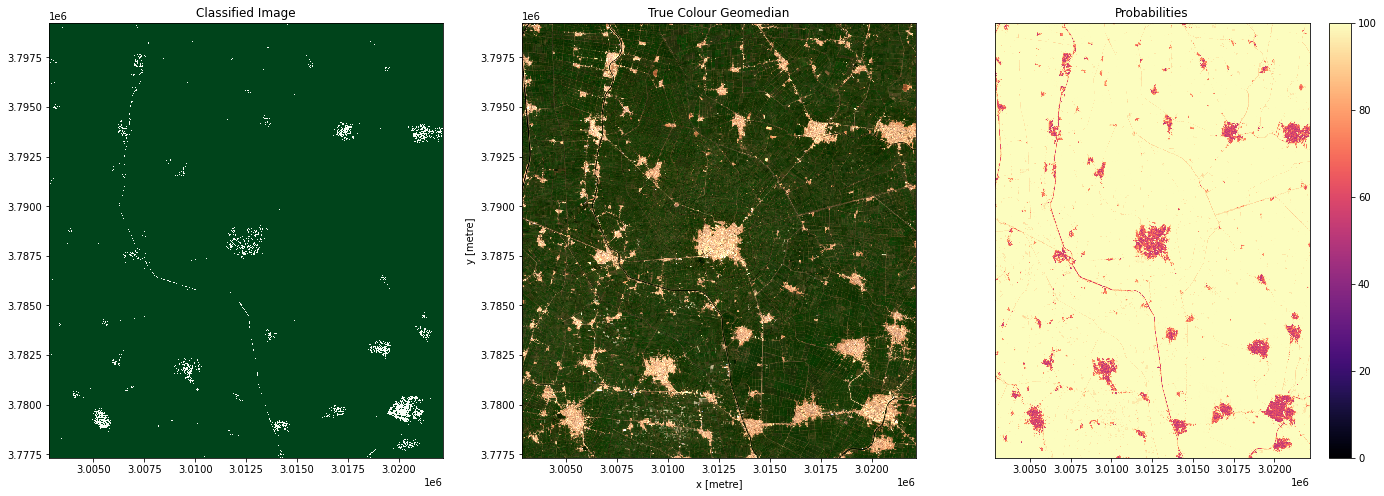

In [11]:
for i in range(0, len(predictions)):
    fig, axes = plt.subplots(1, 3, figsize=(24, 8))


    # Plot classified image
    predictions[i].Predictions.plot(ax=axes[0], 
                   cmap='Greens', 
                   add_labels=False, 
                   add_colorbar=False)

    # Plot true colour image
    rgb(predictions[i], bands=['red','green','blue'],
        ax=axes[1], percentile_stretch=(0.01, 0.99))

    predictions[i].Probabilities.plot(ax=axes[2], 
                   cmap='magma',
                   vmin=0,
                   vmax=100,
                   add_labels=False, 
                   add_colorbar=True)

    # Remove axis on right plot
    axes[2].get_yaxis().set_visible(False)

    # Add plot titles
    axes[0].set_title('Classified Image')
    axes[1].set_title('True Colour Geomedian')
    axes[2].set_title('Probabilities');

## Large scale classification

If you're happy with the results of the test locations, then attempt to classify a large region by re-entering a new latitude, longitude and larger buffer size. You may need to adjust the `dask_chunks` size to optimize for the larger region. If you do change the chunk size, then remember to adjust the chunks in the feature layer function above (i.e. in the default example `feature_layers`)

The cell directly below will first clear the test location results from memory, so we have enough RAM to run a much larger prediction.  

In [12]:
#clear objects from memory
del predictions
del predicted

Enter a new set of coordinates and larger buffer size below. You can use the `display_map()` cell to see an outline of the area you'll be classifying. The default example is centred on the city of Faiyum, Egypt.  Try to keep the buffer size below 0.5, any larger than this and the default sandbox will begin running out of RAM, which interrupts the calculation.

In [13]:
new_lat, new_lon =  29.3037, 30.825 #centred on Faiyum, Egypt
buf_lat, buf_lon = 0.3, 0.5
dask_chunks={'x':1000,'y':1000}

We will now classify the region specified above:

In [15]:
# generate a datacube query object
query = {
    'x': (new_lon-buf_lon, new_lon+buf_lon),
    'y': (new_lat+buf_lat, new_lat-buf_lat),
    'time': time,
    'measurements': measurements,
    'resolution': resolution,
    'output_crs': output_crs,
    'dask_chunks' : dask_chunks,
}

# calculate features lazily
features = feature_layers(query)


#predict using the imported model
predicted = predict_xr(model,
                       features,
                       proba=True,
                       persist=True,
                       clean=True,
                       return_input=True).compute()


predicting...
   probabilities...
   input features...


### Write the results to GeoTIFFs

Our predictions and prediction probabilites are written to disk as Cloud-Optimised GeoTIFFs.  In addition to exporting the predictions, we will also export one of the feature layers, NDVI. In the next notebook, `5_Object-based_filtering`, we will look at using image segmentation to clean up the pixel-based results. The NDVI layer will provide an input to the image segmentation algorithm.


In [16]:
write_cog(predicted.Predictions, results+'prediction.tif', overwrite=True)
write_cog(predicted.Probabilities, results+'probabilities.tif', overwrite=True)
write_cog(predicted.NDVI, results+'NDVI.tif', overwrite=True)

PosixPath('results/NDVI.tif')

### Plot the result

Below, we will plot our pixel based cropland mask for the region around the city of Faiyum, Egypt.

> **Note:** This could crash the kernel if the region is very large, but should be fine if you're using the default example.

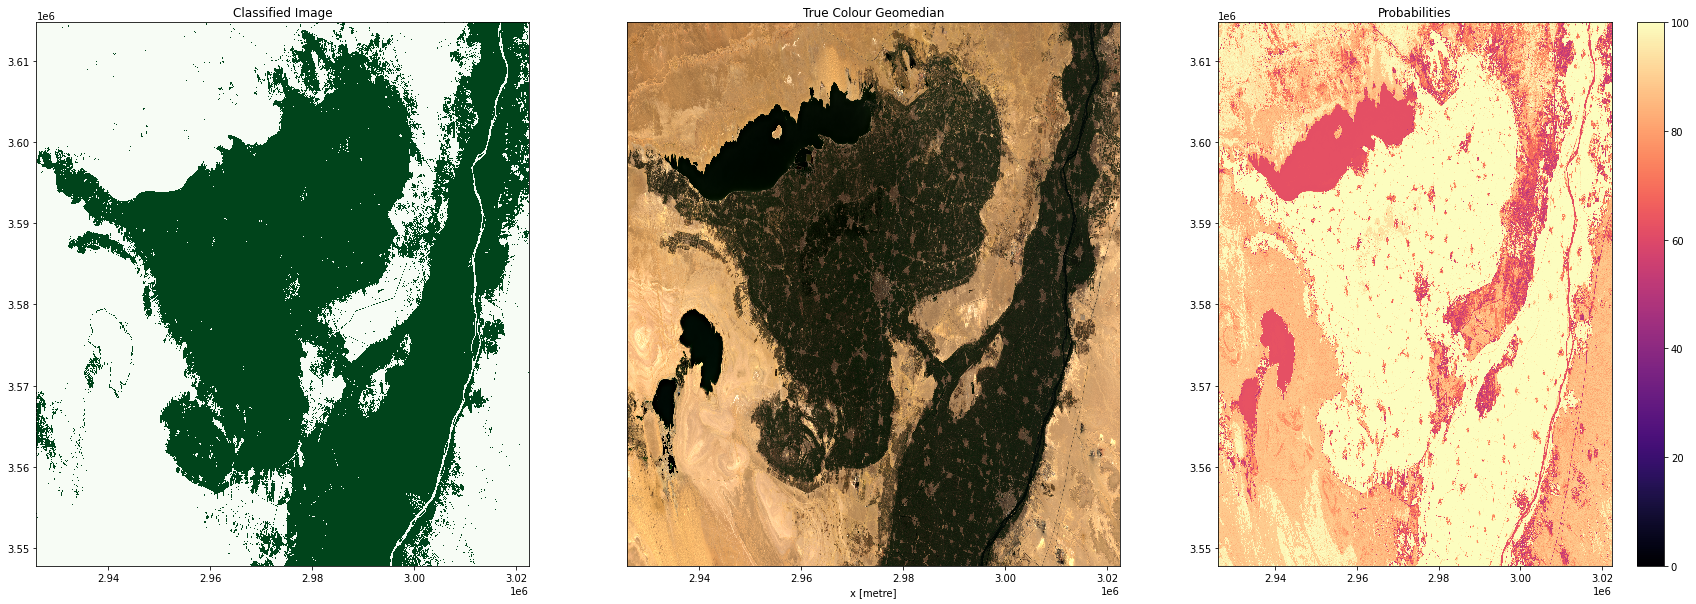

In [17]:
fig, axes = plt.subplots(1, 3, figsize=(30, 10))

# Plot classified image
predicted.Predictions.plot(ax=axes[0], 
               cmap='Greens', 
               add_labels=False, 
               add_colorbar=False)

# Plot true colour image
rgb(predicted,
        ax=axes[1], percentile_stretch=(0.01, 0.99))
    
predicted.Probabilities.plot(ax=axes[2], 
               cmap='magma',
               vmin=0,
               vmax=100,
               add_labels=False, 
               add_colorbar=True)

#Remove axis on right plot
axes[1].get_yaxis().set_visible(False)

#Add plot titles
axes[0].set_title('Classified Image')
axes[1].set_title('True Colour Geomedian')
axes[2].set_title('Probabilities');

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

In [18]:
print(datacube.__version__)

1.8.6


**Last Tested:**

In [19]:
from datetime import datetime
datetime.today().strftime('%Y-%m-%d')

'2022-05-04'